In [7]:
import dask
import dask.bag as db
import dask.dataframe as dd
import json, glob, os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import difflib
import numpy as np
from scipy.optimize import linear_sum_assignment
import pickle
from collections import Counter
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

In [ ]:
if __name__ == "__main__":
    dask.config.set(scheduler="threads")

    DATA_DIR   = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data"
    OUT_DIR    = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data"
    PLAY_OUT   = os.path.join(OUT_DIR, "playlists_parquet")
    TRACKS_OUT = os.path.join(OUT_DIR, "tracks_parquet")

    os.makedirs(OUT_DIR, exist_ok=True)

    fnames = sorted(glob.glob(fr"{DATA_DIR}\mpd.slice.*.json"))
    if not fnames:
        raise FileNotFoundError("Cant find any file")


    bag = db.from_sequence(fnames).map(lambda p: json.load(open(p, "r", encoding="utf-8")))

   
    playlists = bag.pluck("playlists").flatten()

    # to get a dataframe of the playlists 
    playlist_df = playlists.map(lambda p: {
        "pid": p.get("pid"),
        "name": p.get("name"),
        "collaborative": p.get("collaborative"),
        "modified_at": p.get("modified_at"),
        "num_tracks": p.get("num_tracks"),
        "num_albums": p.get("num_albums"),
        "num_followers": p.get("num_followers"),
        "num_edits": p.get("num_edits"),
        "duration_ms": p.get("duration_ms"),
        "num_artists": p.get("num_artists"),
    }).to_dataframe()

    for col in ["pid","modified_at","num_tracks","num_albums","num_followers","num_edits","duration_ms","num_artists"]:
        playlist_df[col] = dd.to_numeric(playlist_df[col], errors="coerce")
    playlist_df["collaborative"] = (playlist_df["collaborative"] == "true")

    # DF tracks 
    tracks_bag = playlists.map(lambda p: [
        {
            "pid": p.get("pid"),
            "pos": t.get("pos"),
            "track_uri": t.get("track_uri"),
            "track_name": t.get("track_name"),
            "artist_uri": t.get("artist_uri"),
            "artist_name": t.get("artist_name"),
            "album_uri": t.get("album_uri"),
            "album_name": t.get("album_name"),
            "track_duration_ms": t.get("duration_ms"),
        } for t in p.get("tracks", [])
    ]).flatten()
    tracks_df = tracks_bag.to_dataframe()
    for c in ["pid","pos","track_duration_ms"]:
        tracks_df[c] = dd.to_numeric(tracks_df[c], errors="coerce")

    #write in parquet to handle big dataset
    playlist_df.to_parquet(PLAY_OUT, write_index=False)
    tracks_df.to_parquet(TRACKS_OUT, write_index=False)

    print("OK: write parquet in", OUT_DIR)

Processing only the first 1000 files: ['D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.0-999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.1000-1999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.10000-10999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.100000-100999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.101000-101999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.102000-102999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.103000-103999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.104000-104999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.105000-105999.json', 'D:\\Computing Foundations of Data Sciences\\EXAM\\dataset\\data\\mpd.slice.106000-106999.json', 'D:\\

Playlists: 985000
Tracks rows: 65341560
Avg num_tracks: 66.33660913705583
% collaborative: 2.2571573604060915
Avg track duration (ms): 234834.51184890597


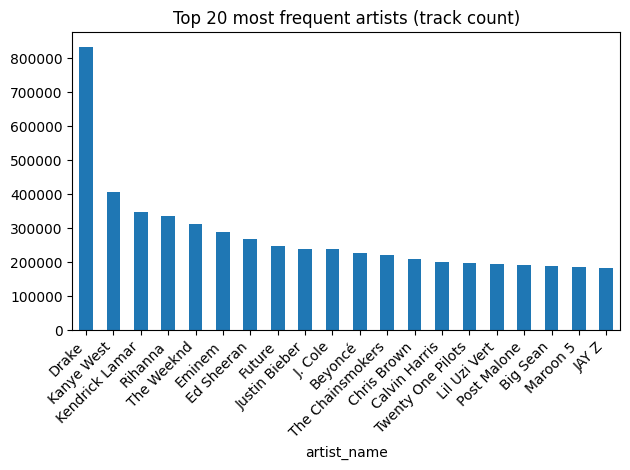

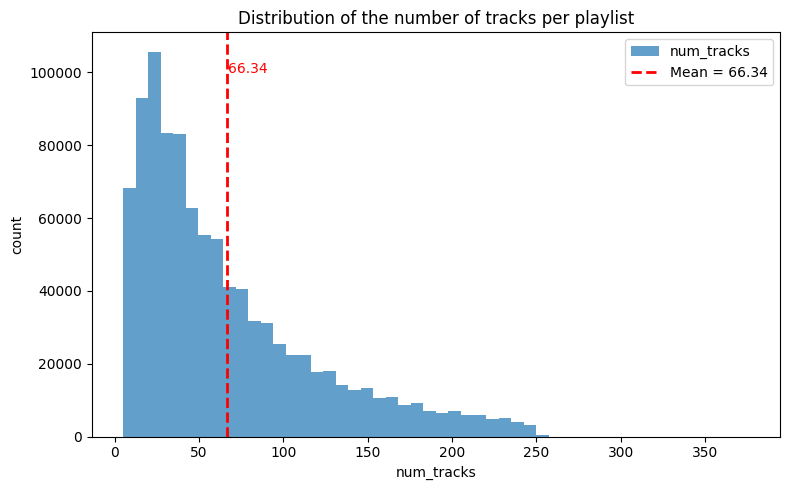

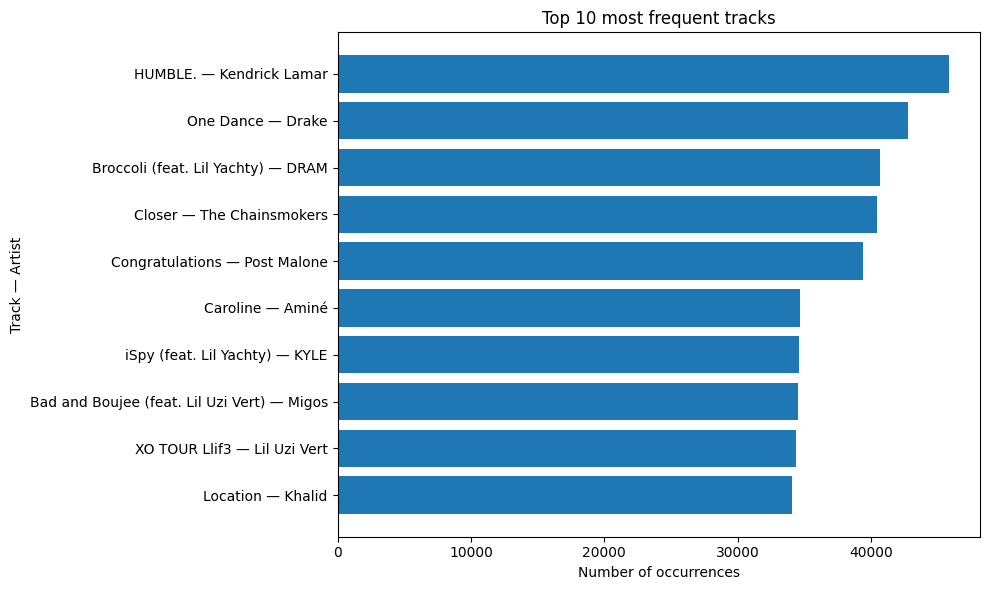

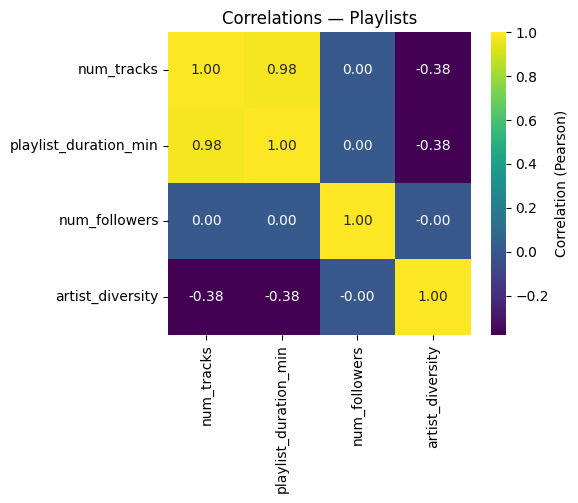

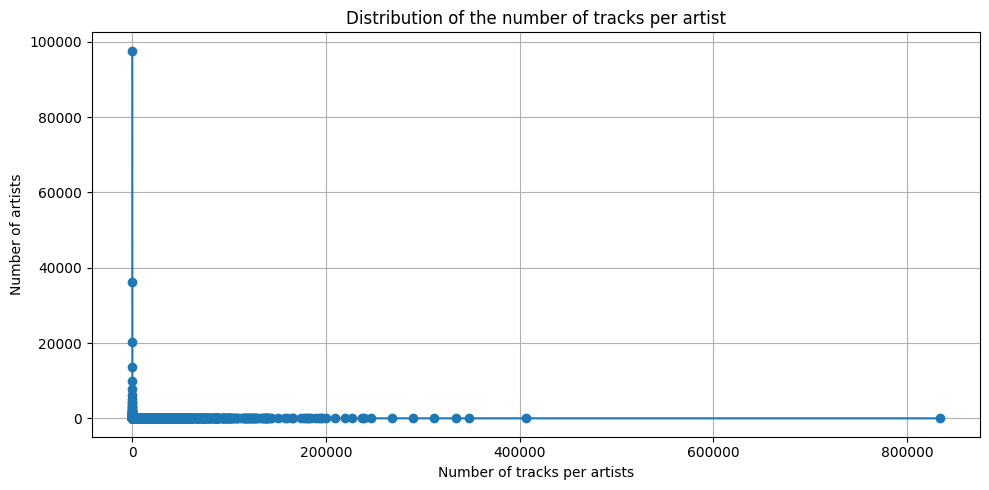

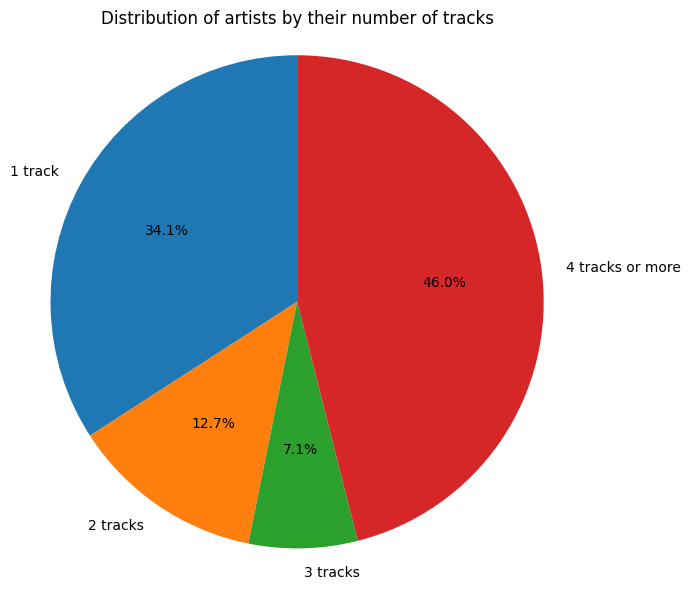

In [19]:
PLAY = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\playlists_parquet"
TRAK = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\tracks_parquet"

dfp = dd.read_parquet(PLAY)  # playlists
dft = dd.read_parquet(TRAK)  # tracks

# Statistiques basiques 
print("Playlists:", len(dfp))
print("Tracks rows:", len(dft))
print("Avg num_tracks:", dfp["num_tracks"].mean().compute())
print("% collaborative:", (dfp["collaborative"].mean().compute()) * 100)
print("Avg track duration (ms):", dft["track_duration_ms"].mean().compute())


top_artists = dft["artist_name"].value_counts().nlargest(20).compute()
top_artists.plot(kind="bar")
plt.title("Top 20 most frequent artists (track count)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


mean_num_tracks = dfp["num_tracks"].mean().compute()

# Plot Histogram 
plt.figure(figsize=(8,5))
dfp["num_tracks"].compute().plot(kind="hist", bins=50, alpha=0.7)

# Red vertical line representing the mean 
plt.axvline(mean_num_tracks, color='red', linestyle='--', linewidth=2,label=f"Mean = {mean_num_tracks:.2f}")


plt.text(mean_num_tracks + 1, plt.ylim()[1]*0.9,f"{mean_num_tracks:.2f}", color='red')

plt.title("Distribution of the number of tracks per playlist");plt.xlabel("num_tracks");plt.ylabel("count");plt.legend();plt.tight_layout();plt.show()


top10 = (
    dft.groupby(['track_uri', 'track_name', 'artist_name'])
             .size()
             .compute()
             .reset_index(name='count')
             .sort_values('count', ascending=False)
             .head(10)
)

# Label "Title — Artist"
top10['label'] = top10['track_name'].fillna('(unknown)') + " — " + top10['artist_name'].fillna('(unknown)')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top10['label'][::-1], top10['count'][::-1])
plt.title("Top 10 most frequent tracks")
plt.xlabel("Number of occurrences")
plt.ylabel("Track — Artist")
plt.tight_layout()
plt.show()


pl_dd = dfp.assign(
    playlist_duration_min = dfp['duration_ms'] / 60000.0,
    artist_diversity      = dfp['num_artists'] / dfp['num_tracks']
)

# Avoid divide by 0
pl_dd['artist_diversity'] = pl_dd['artist_diversity'].where(pl_dd['num_tracks'] > 0)

cols = ['num_tracks', 'playlist_duration_min', 'num_followers', 'artist_diversity']

# switch to pandas for compute the corr
pdf = pl_dd[cols].astype(float).dropna().compute()

# Correlation (Pearson)
corr = pdf.corr(method='pearson', numeric_only=True)

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cmap="viridis",
            cbar_kws={'label': 'Correlation (Pearson)'})
plt.title("Correlations — Playlists")
plt.tight_layout()
plt.show()



# count number of tracks per artist
counts = (
    dft.groupby("artist_name")
             .size()
             .compute()
             .reset_index(name="num_tracks")
)

# Distribution : how many artists have 1, 2, 3... differents tracks in the dataset
dist = counts["num_tracks"].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(dist.index, dist.values, marker="o", linestyle="-")
plt.title("Distribution of the number of tracks per artist")
plt.xlabel("Number of tracks per artists")
plt.ylabel("Number of artists")
plt.grid(True)
plt.tight_layout()
plt.show()


counts = (
    dft.groupby("artist_name")
             .size()
             .compute()
)

# Categorisation
one     = (counts == 1).sum()
two     = (counts == 2).sum()
three   = (counts == 3).sum()
fourp   = (counts >= 4).sum()

sizes = [one, two, three, fourp]
labels = [
    "1 track",
    "2 tracks",
    "3 tracks",
    "4 tracks or more"
]

plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Distribution of artists by their number of tracks")
plt.axis("equal")
plt.show()

# Exercise 3

In [18]:
#paths to the data
PLAY = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\playlists_parquet"
TRAK = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\tracks_parquet"

#We use Pickle for the "get_track_to_pids" function 
# Pickle will stock a pre-calculated index for faster retrieval 
CACHE_DIR = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
PIDS_PICKLE = os.path.join(CACHE_DIR, "track_to_pids.pkl")

TRACK_TO_PIDS = None

# Dask
dfp = dd.read_parquet(PLAY).partitions
dft = dd.read_parquet(TRAK).partitions

# Minimal projection useful for similarity
TRACK_COLS = [
    "track_uri", "track_name",
    "artist_uri", "artist_name",
    "album_uri", "album_name"
]

class TrackSimilarityCalculator:
    def __init__(self, pickle_path, dask_tracks_df=None):            
        """Init calculator. Loads or builds the Jaccard index."""
        self.pickle_path = pickle_path
        self.dask_tracks_df = dask_tracks_df
        self.track_to_pids = self._load_or_build_index()          
        print("Calculator ready.")

    def _load_or_build_index(self):                                  # get list of pids that contains the track
        """Internal: Load pickle or build from Dask."""              # load from cache if index is already available (with pickle)
        if os.path.exists(self.pickle_path):
            print(f"Loading index from cache...")
            with open(self.pickle_path, "rb") as f:
                return pickle.load(f)
        
        print("Building index from Dask (hang tight)...")            # build index if not
        if self.dask_tracks_df is None:
            raise ValueError("Missing pickle and dataframe. Can't build index.")

        # Read only needed cols
        ddf = self.dask_tracks_df[["track_uri", "pid"]]
        pdf = ddf.dropna(subset=["track_uri"]).astype({"pid": "int64"}).compute()
        
        # Groupby to build sets
        lookup = (
            pdf.groupby("track_uri")["pid"]
               .apply(lambda s: set(s.values))
               .to_dict()
        )
        
        # Save cache                                                 # once the index is built, serialize it with pickle
        with open(self.pickle_path, "wb") as f:
            pickle.dump(lookup, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        return lookup

    def compute_jaccard(self, uri_a, uri_b):
        """Calc Jaccard sim (co-occurrence)."""
        sA = self.track_to_pids.get(uri_a, set())
        sB = self.track_to_pids.get(uri_b, set())

        if not sA or not sB:
            return 0.0

        intersection = len(sA & sB)
        union = len(sA | sB)
        return intersection / union if union > 0 else 0.0

    def compute_content_score(self, t1, t2):
        """Calc content sim (Artist, Album, Name)."""
        score = 0.0
        
        # 1. Artist match (weight 0.6)
        if t1.get('artist_uri') and t1.get('artist_uri') == t2.get('artist_uri'):
            score += 0.6
            
            # 2. Album match (weight 0.3) - only if artist matches
            if t1.get('album_uri') == t2.get('album_uri'):
                score += 0.3

        # 3. Title fuzz match (weight 0.1)
        name_a = (t1.get('track_name') or "").strip().lower()
        name_b = (t2.get('track_name') or "").strip().lower()
        
        if name_a and name_b:
            if difflib.SequenceMatcher(None, name_a, name_b).ratio() > 0.7:
                score += 0.1
                
        return min(score, 1.0)

    # final similarity score with both components
    def calculate_similarity(self, t1, t2, weight_jaccard = 0.5):
        """Main entry: Hybrid similarity."""
        # 0. Quick check: Same track?
        uri_a = t1.get("track_uri")
        uri_b = t2.get("track_uri")
        if uri_a and uri_a == uri_b:
            return 1.0

        # 1. Jaccard (Behavior)
        score_jaccard = self.compute_jaccard(uri_a, uri_b)

        # 2. Content (Metadata)
        score_content = self.compute_content_score(t1, t2)

        # 3. Weighted sum: Jaccard (0.7) + Content (0.3)
        final_score = (score_jaccard * weight_jaccard) + (score_content * (1 - weight_jaccard))
        
        return final_score


# Helper Functions

# clean the row to avoid Nones
def norm_track_row(row):                                       
    """Clean data, handle Nones."""
    return {
        "track_uri": (row.get("track_uri") or "").strip(),
        "track_name": (row.get("track_name") or "").strip(),
        "artist_uri": row.get("artist_uri") or "",
        "artist_name": row.get("artist_name") or "",
        "album_uri": row.get("album_uri") or "",
        "album_name": row.get("album_name") or "",
    }

# convert dataframe into list of dictionnaries
def rows_to_items(df):
    if df is None or len(df) == 0:
        return []
    return [norm_track_row(r) for r in df.to_dict("records")]

def get_tracks_by_pid(pid, limit=None):
    """Fetch tracks for a PID from Dask."""
    pdf = dft.loc[dft["pid"] == pid, TRACK_COLS].compute()
    return pdf.head(limit) if limit is not None else pdf


# Global Calculator Instance

# Instantiate here to avoid reloading data repeatedly
calculator = TrackSimilarityCalculator(pickle_path=PIDS_PICKLE, dask_tracks_df=dft)

Loading index from cache...
Calculator ready.


### Examples:

In [10]:
# define the three pairs of Track URIs to compare(the first group has the same singer, the second one has the same type of songs, the third one is completely different)
pairs_to_compare = [
    ("spotify:track:4I2GqMe7L2ccMpUbnDzYLH", "spotify:track:2eJ8ij1T3cNUKiGdcUvKhy"),
    ("spotify:track:1AWQoqb9bSvzTjaLralEkT", "spotify:track:4omisSlTk6Dsq2iQD7MA07"),
    ("spotify:track:7yyRTcZmCiyzzJlNzGC9Ol", "spotify:track:7yq4Qj7cqayVTp3FF9CWbm")
]

# get metadata dictionary for a single track from the Dask DataFrame
def get_track_metadata(uri):
    # Search for a URI in dft and return a dictionary formatted for calculate_similarity.
    # Filter for the URI in dft
    subset = dft[dft['track_uri'] == uri][TRACK_COLS]
    
    try:
        pdf = subset.head(1)
    except Exception as e:
        print(f"Error fetching {uri}: {e}")
        return {}

    if len(pdf) == 0:
        print(f"Can't find Track {uri}.")
    
    # clean data
    return norm_track_row(pdf.iloc[0])

# Loop through and calculate similarity
print(f"\n{'='*10} Starting Similarity Calculation {'='*10}\n")

for i, (uri_a, uri_b) in enumerate(pairs_to_compare, 1):
    print(f"--- Group {i} ---")
    
    # get data objects
    t1_data = get_track_metadata(uri_a)
    t2_data = get_track_metadata(uri_b)
    
    # print track names to verify we grabbed the right songs (if data exists)
    name_a = t1_data.get('track_name', 'Unknown Name')
    name_b = t2_data.get('track_name', 'Unknown Name')
    print(f"Track A: {name_a} ({uri_a})")
    print(f"Track B: {name_b} ({uri_b})")
    
    # calculate
    similarity = calculator.calculate_similarity(t1_data, t2_data)
    
    print(f"Similarity Score: {similarity:.4f}")
    print("\n")


========== Starting Similarity Calculation ==========

--- Group 1 ---
Track A: Somebody To Love (spotify:track:4I2GqMe7L2ccMpUbnDzYLH)
Track B: Baby (spotify:track:2eJ8ij1T3cNUKiGdcUvKhy)
Similarity Score: 0.5720


--- Group 2 ---
Track A: Rock Your Body (spotify:track:1AWQoqb9bSvzTjaLralEkT)
Track B: Sk8er Boi (spotify:track:4omisSlTk6Dsq2iQD7MA07)
Similarity Score: 0.0449


--- Group 3 ---
Track A: Broccoli (feat. Lil Yachty) (spotify:track:7yyRTcZmCiyzzJlNzGC9Ol)
Track B: Riptide (spotify:track:7yq4Qj7cqayVTp3FF9CWbm)
Similarity Score: 0.0000




# Exercise 4

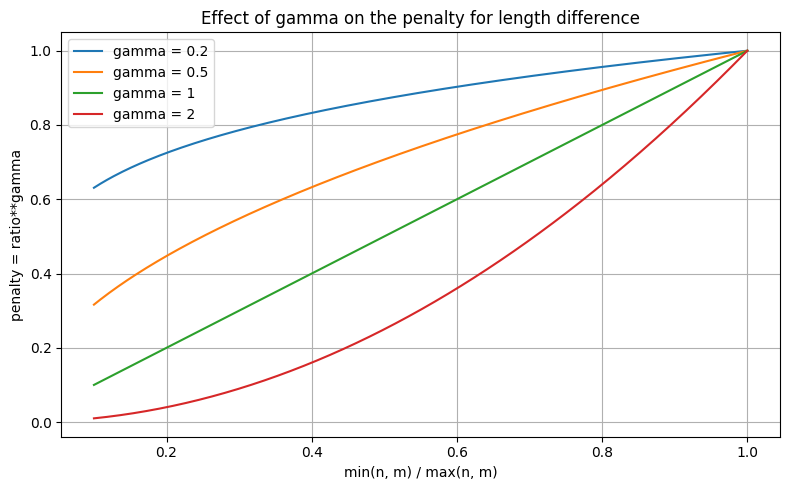

In [5]:
# Here is a first function to compute similarity between playlists
# What it does:
# 1) It computes the similarity between all pairs of tracks such that the first track comes
#    from the first playlist and the second track comes from the second playlist (matrix)
# 2) Using the "linear_sum_assignment" function, it finds the matching between the two playlists
#    that maximizes the total sum of similarity pairs, knowing that each track can be paired
#    with only one track from the other playlist
# 3) To handle differences in playlist lengths, it adds 0 scores (because the final score is
#    divided by N where N is the maximum of the two playlist lengths)

# Advantages:
# 1) Uses the track similarity function from question 3
# 2) The final score equals 1 if and ONLY if the two playlists are exactly identical

# Disadvantages:
# 1) Complexity O(N^3) because it must compute all track-pair similarities (O(n^2)),
#    then optimize the best matching (adds another N factor)
#    Comparing two playlists of roughly 100 tracks is no problem, but if you use this inside
#    an algorithm, you must be careful (although it is doable using some techniques, like putting a limit_tracks)
# 2) It “heavily” penalizes playlist size differences because the size gap is filled with zeros.
#    This penalty can be adjusted without losing any advantage by dividing the final score by the minimum between the 
#    two playlists instead of the maximum and adding a parameter that controls
#    how strongly size differences are penalized ---> see playlist_similarity_hungarian_with_gamma
#    (and the next graph)


def playlist_similarity_hungarian(pid1, pid2, limit_tracks = 1000):
    
    pl1 = dft.loc[dft["pid"] == pid1, TRACK_COLS].head(limit_tracks, compute=True)
    pl2 = dft.loc[dft["pid"] == pid2, TRACK_COLS].head(limit_tracks, compute=True)

    if len(pl1) == 0 or len(pl2) == 0:
        return 0.0
    
    A = [ norm_track_row(pl1.iloc[i]) for i in range(len(pl1)) ]
    B = [ norm_track_row(pl2.iloc[i]) for i in range(len(pl2)) ]

    n = len(A)
    m = len(B)
    N = max(n, m)

    #Construction of the matrix
    cost = np.ones((N, N), dtype=float)

    for i in range(n):
        for j in range(m):
            sim = calculator.calculate_similarity(A[i], B[j])
            cost[i, j] = 1 - sim



    #Finding the optimal matching
    row_ind, col_ind = linear_sum_assignment(cost)

    #We compute the sum
    total_sim = 0.0
    for r, c in zip(row_ind, col_ind):
        if r < n and c < m:
            total_sim += (1 - cost[r, c])
        else:
            total_sim += 0.0 

    final_score = total_sim / N 
    return float(final_score)


# The graph shows how the penalty factor evolves for several given size ratios
# A gamma value below 1 softens the penalty, while a gamma value above 1 increases it

ratios = np.linspace(0.1, 1.0, 300)  # min/max ratios
gammas = [0.2, 0.5, 1, 2]

plt.figure(figsize=(8,5))

for g in gammas:
    plt.plot(ratios, ratios**g, label=f"gamma = {g}")

plt.xlabel("min(n, m) / max(n, m)")
plt.ylabel("penalty = ratio**gamma")
plt.title("Effect of gamma on the penalty for length difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def playlist_similarity_hungarian_with_gamma(pid1, pid2, limit_tracks = 200, gamma = 1.5):

    pl1 = dft.loc[dft["pid"] == pid1, TRACK_COLS].compute().head(limit_tracks)
    pl2 = dft.loc[dft["pid"] == pid2, TRACK_COLS].compute().head(limit_tracks)

    if len(pl1) == 0 or len(pl2) == 0:
        return 0.0
    
    A = [norm_track_row(pl1.iloc[i]) for i in range(len(pl1))]
    B = [norm_track_row(pl2.iloc[i]) for i in range(len(pl2))]

    n, m = len(A), len(B)
    N = max(n,m)

    cost = np.ones((N, N), dtype=float)
    for i in range(n):
        for j in range(m):
            sim = calculator.calculate_similarity(A[i], B[j])
            cost[i, j] = 1 - sim

    row_ind, col_ind = linear_sum_assignment(cost)

    total_sim = 0.0
    for r, c in zip(row_ind, col_ind):
        if r < n and c < m:
            total_sim += (1 - cost[r, c])
        else:
            total_sim += 0.0

    S_hungarian = total_sim / min(n,m)

    length_ratio = min(n, m) / max(n, m)
    penalty = length_ratio ** gamma

    return float(S_hungarian * penalty)




# We've also implement another similarity algorithm: Coverage. Its complexity is O(n^2).
# It simply looks, for each track in one playlist, at the best similarity
# with the set of tracks in the other playlist. Do this for both playlists,
# then take the harmonic mean.
def best_sim_to_set(t, other):

    best = 0.0
    for u in other:
        s = calculator.calculate_similarity(t, u)
        if s > best:
            best = s
            if best >= 1.0:
                return 1.0
    return best
 
def coverage(A, B):

    if not A:
        return 0.0
    acc = 0.0
    for t in A:
        acc += best_sim_to_set(t, B)
    return acc / len(A)
 
def playlist_similarity_coverage(pid_a, pid_b, limit_a, limit_b):

    dfA = get_tracks_by_pid(pid_a, limit=limit_a)
    dfB = get_tracks_by_pid(pid_b, limit=limit_b)
 
    A = rows_to_items(dfA)
    B = rows_to_items(dfB)
 
    if not A and not B:
        return 1.0 
 
    R = coverage(A, B)
    P = coverage(B, A)
 
    if P + R == 0.0:
        return 0.0
 
    #harmonic mean
    harmonic_mean = 2 * P * R / (P + R)
    return float(harmonic_mean)

def get_tracks_by_pid(pid, limit=None):
    """
    Return the tracks that are in a playlist

    """
    pdf = dft.loc[dft["pid"] == pid, TRACK_COLS].compute()
    return pdf.head(limit) if limit is not None else pdf
    

def playlist_similarity_coverage(pid_a, pid_b, limit_a=None, limit_b=None):

    dfA = get_tracks_by_pid(pid_a, limit=limit_a)
    dfB = get_tracks_by_pid(pid_b, limit=limit_b)

    A = rows_to_items(dfA)
    B = rows_to_items(dfB)

    if not A and not B:
        return 1.0  # convention

    R = coverage(A, B)  # A -> B
    P = coverage(B, A)  # B -> A

    if P + R == 0.0:
        return 0.0

    return float(2 * P * R / (P + R))  #harmonic mean



## test for the similarity between two playlists


In [ ]:
#same playlist
s_12 = playlist_similarity_hungarian_with_gamma(50, 50, None, 1)
print("pid1 vs pid2:", s_12)
s = playlist_similarity_coverage(50, 50)
print("pid1 vs pid2:", s)


#different playlist rap vs rap
s_12 = playlist_similarity_hungarian_with_gamma(840, 642, 200, 1)
print("pid1 vs pid2:", s_12)
s = playlist_similarity_coverage(840, 642)
print("pid1 vs pid2:", s)

#different playlist rap vs chrismast
s_12 = playlist_similarity_hungarian_with_gamma(840, 842, 200, 1)
print("pid1 vs pid2:", s_12)
s = playlist_similarity_coverage(840, 842)
print("pid1 vs pid2:", s)

pid1 vs pid2: 1.0
pid1 vs pid2: 1.0
pid1 vs pid2: 0.1669580905636292
pid1 vs pid2: 0.2634638135228943
pid1 vs pid2: 0.0005904360499265954
pid1 vs pid2: 0.0008983373329326871


# Exercise 5

In [20]:
class PlaylistRecommender:
    def __init__(self, calculator):
        # inititalize recommender with the calculator instance
        self.calc = calculator
        self.track_to_pids = calculator.track_to_pids
        
        # Cache for PID -> Tracks 
        self.pid_to_tracks_cache = {} 
        
        print("PlaylistRecommender ready.")

    def get_tracks_in_pid(self, pid):
        # given a playlist id, it will return all track uri inside this playlist
        if pid in self.pid_to_tracks_cache:
            return self.pid_to_tracks_cache[pid]
        
        # if not in cache, then search it in dask
        tracks_df = get_tracks_by_pid(pid)
        if len(tracks_df) == 0:
            return set()
            
        uris = set(tracks_df["track_uri"].dropna().values)
        self.pid_to_tracks_cache[pid] = uris
        return uris

    def bulk_fetch_metadata(self, uris):
        # get multiple URIs at once from Dask
        if not uris:
            return {}
            
        # filter uris in dask. Batching recommended for huge lists.
        subset = dft[dft["track_uri"].isin(list(uris))].compute()
        return {r["track_uri"]: norm_track_row(r) for r in subset.to_dict("records")}

    def predict_continuation(self, seed_track_uris, k=5, candidate_pool_size=50):
        #Main recommendation logic
        
        # Retrieval
        neighbor_pids = set()
        
        # find playlists containing seed tracks
        for uri in seed_track_uris:
            pids = self.track_to_pids.get(uri, set())
            neighbor_pids.update(pids)
            
        if not neighbor_pids:
            print("No neighbor playlists found")
            return []

        print(f"Phase 1: Found {len(neighbor_pids)} neighbor playlists.")

        # count track frequency in those playlists
        raw_candidates = Counter()
        
        # limit neighbors to avoid slow loops on huge data
        MAX_NEIGHBORS = 200 
        check_pids = list(neighbor_pids)
        if len(check_pids) > MAX_NEIGHBORS:
            check_pids = random.sample(check_pids, MAX_NEIGHBORS)
            
        for pid in check_pids:
            tracks = self.get_tracks_in_pid(pid)
            for t in tracks:
                raw_candidates[t] += 1
        
        # remove seeds fomm candidates
        for seed in seed_track_uris:
            if seed in raw_candidates: del raw_candidates[seed]
            
        # pick top N candidates
        top_candidates = [uri for uri, _ in raw_candidates.most_common(candidate_pool_size)]
        
        if not top_candidates:
            return []


        # fetch Metadata
        all_needed = set(seed_track_uris) | set(top_candidates)
        meta_lookup = self.bulk_fetch_metadata(all_needed)
        
        # Reranking
        ranked = []
        
        # Debug info
        last_seed = meta_lookup.get(seed_track_uris[-1], {}).get('track_name', 'Unknown')
        print(f"--- Phase 2: Scoring {len(top_candidates)} candidates. Last seed: {last_seed} ---")

        for idx, cand_uri in enumerate(top_candidates):
            meta_b = meta_lookup.get(cand_uri)
            if not meta_b: continue 
            
            w_score = 0.0
            total_w = 0.0
            
            # Compare candidate against all seeds
            for i, seed_uri in enumerate(seed_track_uris):
                # Recent seeds get higher weight
                weight = i + 1 
                
                meta_a = meta_lookup.get(seed_uri)
                if not meta_a: continue

                # Use the calculator to caluclate sim
                sim = self.calc.calculate_similarity(meta_a, meta_b)
                
                w_score += (sim * weight)
                total_w += weight

            final = w_score / total_w if total_w > 0 else 0.0
            ranked.append((cand_uri, final))
            
            if idx < 3:
                print(f"Candidate based on co-occ: {meta_b.get('track_name')} -> {final:.4f}")

        # sort by score desc
        ranked.sort(key=lambda x: x[1], reverse=True)
        
        #Outtput
        recommendations = []
        for uri, score in ranked[:k]:
            meta = meta_lookup.get(uri, {})
            recommendations.append({
                'track_uri': uri,
                'track_name': meta.get('track_name', 'Unknown'),
                'artist_name': meta.get('artist_name', 'Unknown'),
                'score': score
            })
            
        return recommendations



def search_track_uri(search_term, artist_term=None):
    # Helper to find a real track URI from the dataset based on name
    # Note: This scans the dask dataframe, might be slow if dataset is huge.
    
    # simple regex search
    mask = dft['track_name'].str.contains(search_term, case=False, na=False)
    if artist_term:
        mask = mask & dft['artist_name'].str.contains(artist_term, case=False, na=False)
        
    subset = dft[mask].head(5, npartitions=-1) # Take top 5 matches
    
    if len(subset) == 0:
        print(f"Could not find track '{search_term}' by '{artist_term}'")
        return None
    
    # Return the first match's URI and info
    row = subset.iloc[0]
    return row['track_uri'], f"{row['track_name']} - {row['artist_name']}"

def run_test_scenario(scenario_name, seed_queries, recommender):
    print(f"\n{'='*20} SCENARIO: {scenario_name} {'='*20}")
    
    seed_uris = []
    print("Seeds:")
    for q_track, q_artist in seed_queries:
        result = search_track_uri(q_track, q_artist)
        if result:
            uri, display_name = result
            seed_uris.append(uri)
            print(f" - Found: {display_name} ({uri})")
    
    if not seed_uris:
        print("No valid seeds found.")
        return

    print(f"\nGenerating recommendations based on {len(seed_uris)} seeds...")
    recs = recommender.predict_continuation(seed_uris, k=5)
    
    print("\nRecommendations:")
    if not recs:
        print("No rec found.")
    else:
        for i, r in enumerate(recs):
            print(f" {i+1}. {r['track_name']} (by {r['artist_name']}) [Score: {r['score']:.4f}]")

In [21]:
if __name__ == "__main__":
    # initialize recommender
    recommender = PlaylistRecommender(calculator)
    
    # Here i listed some scenarios, I used them to teest whether the recommemder system works, if it works we will see similar songs inside rec list
    # I chose randomly the songs, I believe that they are similar(hopefully)
    # 1.Scenario: K-Pop
    run_test_scenario(
        "K-Pop",
        [
            ("DNA", "BTS"),
            ("As If It's Your Last", "BLACKPINK"),
            ("Mr. Simple", "Super Junior")
        ],
        recommender
    )

    # 2.Scenario: Classic Rock
    run_test_scenario(
        "Classic Rock",
        [
            ("Bohemian Rhapsody", "Queen"),
            ("Hotel California", "Eagles"),
            ("Sweet Child O' Mine", "Guns N' Roses")
        ],
        recommender
    )

    # 3.Scenario: Modern Pop
    run_test_scenario(
        "2010s Pop Hits",
        [
            ("Shape of You", "Ed Sheeran"),
            ("Closer", "The Chainsmokers"),
            ("Cheap Thrills", "Sia")
        ],
        recommender
    )
    
    # 4.Scenario: Taylor Swift
    run_test_scenario(
        "Taylor Swift Fan",
        [
            ("Love Story", "Taylor Swift"),
            ("Blank Space", "Taylor Swift"),
            ("Shake It Off", "Taylor Swift")
        ],
        recommender
    )

PlaylistRecommender ready.

==================== SCENARIO: K-Pop ====================
Seeds:
 - Found: DNA - BTS (spotify:track:5SE57ljOIUJ1ybL9U6CuBH)
 - Found: As If It's Your Last - BLACKPINK (spotify:track:1Zyd6zQnC6XIIzmg3hP7Ot)
 - Found: Mr. Simple - Super Junior (spotify:track:1EBA71Up4r13q6ggBCwBdJ)

Generating recommendations based on 3 seeds...
Phase 1: Found 6 neighbor playlists.
--- Phase 2: Scoring 50 candidates. Last seed: Mr. Simple ---
Candidate based on co-occ: Intro: Serendipity -> 0.2417
Candidate based on co-occ: dimple -> 0.2417
Candidate based on co-occ: Blood Sweat & Tears -> 0.1426

Recommendations:
 1. STAY - KR Ver. (by BLACKPINK) [Score: 0.2750]
 2. Intro: Serendipity (by BTS) [Score: 0.2417]
 3. dimple (by BTS) [Score: 0.2417]
 4. MIC Drop (by BTS) [Score: 0.2417]
 5. WHISTLE - KR Ver. (by BLACKPINK) [Score: 0.2389]

==================== SCENARIO: Classic Rock ====================
Seeds:
 - Found: Bohemian Rhapsody - Remastered 2011 - Queen (spotify:track:1A

# Second method : KNN 

In [ ]:
random_seed = 100 #for reproductability
#we use 100% of the dataset, but we can change it by changing frac
dft = dd.read_parquet( r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\tracks_parquet").sample(frac=0.5,random_state = random_seed).compute()

dft["track_id"] = dft["track_uri"].astype("category").cat.codes
 
rows = dft["pid"].values #get the playlists value
cols = dft["track_id"].values  #get the tracks value
data = np.ones(len(rows), dtype=np.float32)
 
n_playlists = rows.max() + 1
n_tracks = cols.max() + 1
 
#construction of the sparse matrix playlist x track
mat = sp.csr_matrix((data, (rows, cols)), shape=(n_playlists, n_tracks))
 
#Vector space of dimension 50
svd = TruncatedSVD(n_components=50,random_state=random_seed)
 
#Project the matrix onto this vector space to create embeddings
emb = svd.fit_transform(mat)
emb = normalize(emb)
 
knn = NearestNeighbors(n_neighbors=15, metric="euclidean")
#Applying KNN model on theses embeddings
knn.fit(emb)
def recommend(pid, top_k=20):
    distances, neighbors = knn.kneighbors([emb[pid]])
 
    # 1)remove the self-neighbor
    neighbor_pids = neighbors[0]
    neighbor_pids = neighbor_pids[neighbor_pids != pid]
 
    #all tracks that are in the neighbors
    subset = dft[dft["pid"].isin(neighbor_pids)]
 
    # 2)remove tracks that are already in the playlist
    already = set(dft.loc[dft["pid"] == pid, "track_uri"])
    vc = subset["track_uri"].value_counts()
    vc = vc[~vc.index.isin(already)]
 
    # top tracks mostly frequent in the neighbors
    top = vc.nlargest(top_k)
 
    return top.index.tolist()



TRAK = r"D:\Computing Foundations of Data Sciences\EXAM\dataset\data\tracks_parquet"

# 1) transform track uri to track name
ddf_lookup = dd.read_parquet(TRAK, columns=["track_uri", "track_name", "artist_name"])
track_lookup = (
    ddf_lookup
    .drop_duplicates()
    .compute()
    .dropna(subset=["track_uri"])
    .drop_duplicates(subset=["track_uri"])
    .set_index("track_uri")[["track_name", "artist_name"]]
)
 
#function that convert uri of the recommend function to track name
def recommend_names(pid, top_k=20):
    uris = recommend(pid, top_k)
 
    df = track_lookup.reindex(uris).reset_index()
    df.columns = ["track_uri", "track_name", "artist_name"]
 
    df["track_name"] = df["track_name"].fillna("(unknown)")
    df["artist_name"] = df["artist_name"].fillna("(unknown)")
    return df
 
pid = 12346
print(recommend_names(pid, top_k=15))
 
for _, r in recommend_names(pid, top_k=15).iterrows():
    print(f"{r.track_name} / {r.artist_name}")

                               track_uri  \
0   spotify:track:40dJCw4xU6Bd5ie9rfagNo   
1   spotify:track:2VNfJpwdEQBLyXajaa6LWT   
2   spotify:track:7aS418hRnOnYrXeyrZilwk   
3   spotify:track:4NnWuGQujzWUEg0uZokO5M   
4   spotify:track:7FlwylpJSe3ea6m1IrkizS   
5   spotify:track:0KlJjhnfwAnPacNd7EH45J   
6   spotify:track:2S3flt2KfOpG7JNmtteAAZ   
7   spotify:track:7jTKLKs3NDmDnJHan5M2A0   
8   spotify:track:2EEinN4Zk8MUv4OQuLsTBj   
9   spotify:track:1YwNlWLf8auhazSQUDQLFU   
10  spotify:track:1TAAAbxtkJuq8SK4HyQdtJ   
11  spotify:track:7LyIoUsiMtelB1I0I4drEF   
12  spotify:track:0USXb7vV2uLFdhjBmxAIgk   
13  spotify:track:3OM0cHwmJv6ZpsCgrEzXPh   
14  spotify:track:4xiyq1iRdsxuU1BPUJ490Z   

                                    track_name      artist_name  
0            Everybody Wants To Rule The World  Tears For Fears  
1          Burning Down The House (45 Version)    Talking Heads  
2   A Little Respect - 2009 Remastered Version          Erasure  
3                             J